In [1]:
import pandas as pd
import cupy as cp
import numpy as np
import pickle
import spacy
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr
from sklearn.feature_selection import chi2
from sklearn.feature_extraction.text import TfidfVectorizer
from tqdm import tqdm

In [163]:
corp = 'swe'

In [164]:
vectorizer = pickle.load(open("/maps/hdir/gsw508/Thesis/" + corp + "_vectorizer.pickle", "rb"))

In [165]:
features = pd.read_pickle("/maps/hdir/gsw508/Thesis/" + corp + "_features.pickle")

In [166]:
party_df = pd.read_json(corp + '_party_df.json')

In [167]:
#features' correlation with y
def conn_to_y (x):
    return float(cp.corrcoef(x, y)[0][1]);

In [168]:
party_df[['soc', 'rel', 'eth', 'urb', 'pos', 'for']] = 0

In [169]:
X_names = pd.DataFrame(vectorizer.get_feature_names_out()) # initial topic of interest for testing

In [170]:
X_names = X_names.rename(columns={0: 'name'})

In [194]:
lookup = X_names.loc[X_names['name'] == 'välfärd']
lookup

,name
47841,välfärd


In [195]:
topic_id = lookup.index[0]

In [196]:
# Define batch size
batch_size = 500
temp = lambda x,y: [ x[i:i+y] for i in range(0,len(x),y)]
last_batch_size = [len(i) for i in temp(range(1, features.shape[1]), batch_size)][-1]
last_batch_pos = len([len(i) for i in temp(range(1, features.shape[1]), batch_size)])


# topic of interest
y = cp.asarray(features[:, topic_id].toarray().T[0])

# Initialize p and batch pos
p = []
n = 0

# Loop through batches of X and compute correlations
for i in tqdm(range(0, features.shape[1], batch_size)):
    # Get current batch of X
    if n == last_batch_pos:
        X_batch = cp.asarray(features[:, i:i+last_batch_size].toarray())
    else:
        X_batch = cp.asarray(features[:, i:i+batch_size].toarray())
        
    # Compute correlations for current batch
    p_batch = cp.apply_along_axis(conn_to_y, 0, X_batch)
    
    # Store results for current batch
    p.append(p_batch)
    n += 1
    
#find top predictive features
p_temp = cp.empty(0)

n = 0
for batch in p:
    for i in batch:
        p_temp = cp.append(p_temp, i)
        

100%|█████████████████████████████████████████| 101/101 [02:45<00:00,  1.64s/it]


In [197]:
#highest-ranked features and their Pearson r's
p_rank = cp.argsort(p_temp)
p_top = cp.flip(p_rank[-30:], 0)
#most predictive features
df_top = pd.DataFrame({'feature': X_names.name[[int(x) for x in p_top]],
     'PearsonR': p_temp[[int(x) for x in p_top]].tolist()})

In [198]:
df_top

,feature,PearsonR
47841,välfärd,1.000000
47842,välfärden,0.234606
37428,skatter,0.098111
42670,tillväxt,0.095669
29908,och,0.090370
41236,sysselsättning,0.081593
15177,generell,0.079588
48414,vår,0.075684
47955,välstånd,0.072978
32300,politik,0.072548


socio-economic; religious (traditional values); ethnic (center–periphery, globalism); urban–rural; post-materialist; and foreign policy

In [199]:
aut_topic_dict = {'soc': ['wohlfahrt', 'leistungen', 'leistung', 'armut', 'gesundheitswesen', 'krankenhaus', 'gesundheit',
                          'krankenpflege', 'krankenschwestern', 'patienten', 'medikamente', 'kapitalismus', 'bildung',
                          'schulen', 'hochschulen', 'studenten', 'lehrer', 'bildung', 'kindergarten', 'markt', 'wettbewerb',
                          'verbraucher', 'verbraucher', 'handel', 'gewerkschaften', 'protektionismus', 'zölle',
                          'umverteilung', 'umverteilt', 'umverteilen', 'reichtum', 'umverteilen', 'umverteilen',
                          'umverteilung', 'einkommen', 'pflegegeldverfahren', 'handels', 'freihandel', 'handelsabkommen',
                          'freihandels', 'wirtschaft', 'arbeitsplätze', 'unternehmer', 'unternehmen', 'wirtschaftspolitik'], 
                  'rel': ['christliche', 'christen', 'hochzeit', 'scheidung', 'heterosexuell', 'zusammenleben', 'familie', 
                          'homosexuell', 'homosexuellen', 'heterosexuellen'
                          'scheidungen', 'christlichen', 'christentum', 'christliches', 'kirchen', 'lesbisch', 'homosexualität',
                          'abtreibung', 'abtreibungen', 'schwangerschaft', 'homosexuelle', 'schutzalters', 'hetero', 'lebenspartnerschaft',
                          'gender', 'frauen', 'gleichberechtigung'],
                  'eth': ['zentralisierung', 'dezentralisierung', 'patriotische', 'vaterländer', 'migration', 'kommunal',
                          'föderalismus', 'bundesländergrenzen', 'massenmigration', 'asyl', 'ethnisch', 'volksgruppenpolitik',
                           'lokal', 'regionalisierung', 'regional', 'dezentralisiert', 'superstaat', 'nationalismus',
                          'zentralismus', 'multikulturell', 'kulturen', 'traditionell', 'amtsvorgängerinnen', 'behördenstrukturen',
                          'rassismus', 'minderheiten', 'bürokratischer', 'regionalpolitik', 'kohäsion', 'regionalentwicklung',
                          'regionalpolitischen', 'regionen', 'regionalpolitischen', 'bezirk', 'bezirken'],
                  'urb': ['landwirtschaft', 'landwirte', 'ländlich', 'bauer', 'ackerland', 'bauern', 'agrarpolitik', 'bäuerlichen',
                          'weide', 'bauernhöfe', 'bauernhof', 'molkerei', 'bäuerliche', 'landwirtschaftlichen', 'landwirtschaftliche',
                          'ländliche'],
                  'pos': ['klima', 'emissionen', 'energie', 'erwärmung', 'fossil', 'energiefonds', 'energiestrategie', 'klimaschutz',
                           'co2', 'erneuerbare', 'umwelt', 'umwelt', 'dekarbonisierung', 'global', 'klimawandel',
                           'tier', 'tiere', 'hunde', 'hund', 'vegetarisch', 'nachhaltig', 'nachhaltigkeit',
                           'umweltfreundlich'],
                  'for': ['militär', 'international', 'diplomatie', 'krieg', 'verteidigung', 'ausländisch', 'diplomatisch', 
                          'unilateral', 'diplomatischem', 'außenpolitik', 'partnerland', 'außenministerin', 'außenminister',
                           'außenpolitischen', 'außenpolitische', 'außenamt', 'sicherheitspolitik', 'außenpolitisch',
                           'abrüstung', 'multilateral', 'einseitig', 'unilateralismus', 'multilateral', 'bilateral']}

czc_topic_dict = {'soc': ['prospěch', 'užitek', 'univerzální', 'chudoba', 'zdravotní', 'nemocnice', 'zdraví', 'pojišťovny',
                          'ošetřování', 'pacienti', 'léky', 'kapitalismus', 'vzdělávání', 'blaho', 'blaha', 'pojišťovna',
                          'školy', 'studenti', 'učitelé', 'vzdělávací', 'školky', 'trh', 'konkurence', 'péče', 'péči',
                          'spotřebitel', 'spotřebitelé', 'obchod', 'odbory', 'bohatství', 'zdravotního', 'pojišťoven',
                          'přerozdělování', 'příjem', 'zdravotních', 'zdravotnictví', 'pacientů', 'vzdělání', 'tělovýchovu',
                          'vysokoškolské', 'středoškolské', 'školství', 'školách', 'škol', 'školy', 'veřejné', 'finance',
                          'sociální', 'prospěšnosti', 'služby', 'chudým', 'bohatým', 'chudoba', 'hospodářský', 'hospodářského'], 
                  'rel': ['křesťan', 'manželství', 'rozvod', 'křesťané', 'pohlaví', 'partnerském', 'partnerství', 'manželství',
                          'soužití', 'rodina', 'rozvody', 'homosexuální', 'homosexuálních', 'sexuální', 'stejného', 'párům',
                          'plod', 'těhotenství', 'ženy', 'rovnost', 'párů', 'homosexuálním', 'homosexuálů', 'heterosexuální',
                          'homosexuálové', 'soužití', 'rodina', 'rodiny', 'rodin', 'rodině', 'rodinu', 'pěstounská'],
                  'eth': ['centralizace', 'decentralizace', 'centralizace', 'centralizovat', 'rasy', 'etnického',
                           'místní', 'regionalizace', 'regionální', 'původu', 'etnický', 'pleti', 'superstátu', 'decentralizaci',
                          'multikulturní', 'víry', 'kultury', 'imigrace', 'imigrační', 'samosprávy', 'decentralizací',
                          'rasismus', 'menšiny', 'menšina', 'samospráva', 'krajů'],
                  'urb': ['zemědělství', 'zemědělství', 'zemědělství', 'venkov', 'zemědělskou', 'zemědělské', 'prvovýrobu',
                          'farmy', 'farma', 'farem', 'farmu', 'prasat', 'půdou', 'půdu', 'půdy', 'zemědělských', 'zemědělská'],
                  'pos': ['klima', 'emise', 'uhlík', 'energie', 'skleníkové', 'oteplování', 'klimatu', 'environmentálního',
                           'obnovitelné', 'co2', 'environmentální', 'globální', 'environmentální', 'ekologický', 'uhličitého',
                           'zvíře', 'zvířata', 'psi', 'pes', 'udržitelný', 'udržitelnost', 'oxidu', 'prostředí', 'životního'],
                  'for': ['vojenský', 'mezinárodní', 'diplomacie', 'válka', 'obrana', 'zahraniční', 'diplomatický', 'vojenského',
                          'jednostranný', 'vojenských', 'válečný', 'armáda', 'vojenské', 'vojenským', 'armády', 'zahraničního',
                           'odzbrojení', 'jednostranně', 'dvoustranný', 
                           'oboustranně']}

den_topic_dict = {'soc': ['velfærd', 'ydelser', 'ydelse', 'universel', 'fattigdom', 'sundhedspleje', 'hospital', 'sundhed',
                          'sygepleje', 'sygeplejersker', 'patienter', 'medicin', 'kapitalisme', 'kapitalistisk', 'uddannelse',
                          'skoler', 'højskoler', 'elever', 'lærere', 'pædagogisk', 'vuggestue', 'marked', 'konkurrence',
                          'forbruger', 'forbrugere', 'handel', 'fagforeninger', 'protektionisme', 'velfærden', 'skattelettelser',
                          'omfordele', 'rigdom', 'velfærdssamfund', 'markedet', 'fattigdom', 'nulvækst', 'rigeste', 'omfordelingen',
                          'omfordeling', 'indkomst', 'velstand', 'økonomi', 'pensionsopsparing', 'pension', 'pensionsordning',
                          'fordelingspolitik', 'folkepensionen', 'skatteniveau', 'skatteniveauet', 'beskatning', 'skatteudskrivende',
                          'lønniveau', 'skattegrundlag', 'velfærdstab', 'skattetryk'], 
                  'rel': ['kristen', 'ægteskaber', 'skilsmisse', 'samliv', 'familie', 'homoseksuel', 'skilsmisser',
                          'abort', 'aborter', 'foster', 'ufødte', 'graviditet', 'foster', 'prævention', 'transseksuelle', 
                          'køn', 'kvinder', 'ligestilling', 'kønsskifteoperation', 'sexologisk', 'kønsskifte', 'transkønnede',
                          'ægtefælles', 'kristendom', 'kristent', 'kristendommen', 'kristendomsundervisning', 'kristne',
                          'evangeliskluthersk', 'kirke', 'familien', 'familier', 'familierne', 'familieliv'],
                  'eth': ['centralisering', 'decentralisering', 'centraliseringen', 'centraliseret', 'centralisere',
                           'lokal', 'regionalisering', 'regional', 'decentraliseret', 'kultursammenstød', 'centraliserer',
                          'centralisme', 'multietnisk', 'trosretninger', 'kulturer', 'udflytning', 'yderområderne', 'indvandring',
                          'racisme', 'pluralistisk', 'minoriteter', 'minoritet', 'regionalpolitikken', 'topstyring', 'ikkevestlige',
                          'ikkevestlig', 'udlændingepolitik'],
                  'urb': ['landbrug', 'landmænd', 'landbruget', 'landmand', 'gårde', 'gård', 'mejeri', 'landbrugets',
                          'fødevarer', 'landbrugs', 'landbrugsproduktion', 'landbrugsstøtte', 'jordpriserne', 'landbrugsjord',
                          'jordbrugerfond', 'landbrugskommission', 'landbrugene', 'landbrugslov'],
                  'pos': ['klima', 'emissioner', 'energi', 'opvarmning', 'fossil', 'klimaet', 'klimapolitik', 'klimatopmøde',
                           'vedvarende', 'co2', 'miljø', 'miljømæssig', 'global', 'dyr', 'hunde', 'hund', 'bæredygtig', 
                          'bæredygtighed', 'klimaområdet', 'klimaaftale', 'dyrevelfærd', 'dyremishandling', 'dyrevelfærden',
                           'miljømæssigt'],
                  'for': ['militær', 'international', 'diplomati', 'krig', 'forsvar', 'fremmed', 'diplomatisk',
                           'nedrustning', 'multilateralt', 'multilateralt', 'bilateralt', 'udenrigspolitik',
                           'bilateralt', 'udenrigspolitikken', 'sikkerhedspolitik', 'udenrigspolitisk', 'udenrigspolitiske',
                          'udenrigs', 'forsvarspolitik', 'militære']}

deu_topic_dict = {'soc': ['wohlfahrt', 'leistungen', 'leistung', 'armut', 'gesundheitswesen', 'krankenhaus', 'gesundheit',
                          'krankenpflege', 'krankenschwestern', 'patienten', 'medikamente', 'kapitalismus', 'bildung',
                          'schulen', 'hochschulen', 'studenten', 'lehrer', 'bildung', 'kindergarten', 'markt', 'wettbewerb',
                          'verbraucher', 'verbraucher', 'handel', 'gewerkschaften', 'protektionismus', 'zölle',
                          'umverteilung', 'umverteilt', 'umverteilen', 'reichtum', 'umverteilen', 'umverteilen',
                          'umverteilung', 'einkommen', 'pflegegeldverfahren', 'handels', 'freihandel', 'handelsabkommen',
                          'freihandels', 'wirtschaft', 'arbeitsplätze', 'unternehmer', 'unternehmen', 'wirtschaftspolitik'], 
                  'rel': ['christliche', 'christen', 'hochzeit', 'scheidung', 'heterosexuell', 'zusammenleben', 'familie', 
                          'homosexuell', 'homosexuellen', 'heterosexuellen'
                          'scheidungen', 'christlichen', 'christentum', 'christliches', 'kirchen', 'lesbisch', 'homosexualität',
                          'abtreibung', 'abtreibungen', 'schwangerschaft', 'homosexuelle', 'schutzalters', 'hetero', 'lebenspartnerschaft',
                          'gender', 'frauen', 'gleichberechtigung'],
                  'eth': ['zentralisierung', 'dezentralisierung', 'patriotische', 'vaterländer', 'migration', 'kommunal',
                          'föderalismus', 'bundesländergrenzen', 'massenmigration', 'asyl', 'ethnisch', 'volksgruppenpolitik',
                           'lokal', 'regionalisierung', 'regional', 'dezentralisiert', 'superstaat', 'nationalismus',
                          'zentralismus', 'multikulturell', 'kulturen', 'traditionell', 'amtsvorgängerinnen', 'behördenstrukturen',
                          'rassismus', 'minderheiten', 'bürokratischer', 'regionalpolitik', 'kohäsion', 'regionalentwicklung',
                          'regionalpolitischen', 'regionen', 'regionalpolitischen', 'bezirk', 'bezirken'],
                  'urb': ['landwirtschaft', 'landwirte', 'ländlich', 'bauer', 'ackerland', 'bauern', 'agrarpolitik', 'bäuerlichen',
                          'weide', 'bauernhöfe', 'bauernhof', 'molkerei', 'bäuerliche', 'landwirtschaftlichen', 'landwirtschaftliche',
                          'ländliche'],
                  'pos': ['klima', 'emissionen', 'energie', 'erwärmung', 'fossil', 'energiefonds', 'energiestrategie', 'klimaschutz',
                           'co2', 'erneuerbare', 'umwelt', 'umwelt', 'dekarbonisierung', 'global', 'klimawandel',
                           'tier', 'tiere', 'hunde', 'hund', 'vegetarisch', 'nachhaltig', 'nachhaltigkeit',
                           'umweltfreundlich'],
                  'for': ['militär', 'international', 'diplomatie', 'krieg', 'verteidigung', 'ausländisch', 'diplomatisch', 
                          'unilateral', 'diplomatischem', 'außenpolitik', 'partnerland', 'außenministerin', 'außenminister',
                           'außenpolitischen', 'außenpolitische', 'außenamt', 'sicherheitspolitik', 'außenpolitisch',
                           'abrüstung', 'multilateral', 'einseitig', 'unilateralismus', 'multilateral', 'bilateral']}

eng_topic_dict = {'soc': ['welfare', 'benefits', 'benefit', 'universal', 'poverty', 'healthcare', 'nhs', 'hospital', 'health',
                         'nursing', 'nurses', 'patients', 'medicines', 'laissezfaire', 'capitalism', 'capitalist', 'education',
                         'schools', 'colleges', 'students', 'teachers', 'educational', 'nursery', 'market', 'competition',
                         'consumer', 'consumers', 'trade', 'unions', 'protectionism', 'protectionist', 'tarrifs', 
                         'redistribution', 'redistributed', 'redistribute', 'wealth', 'redistribute', 'redistributive',
                         'redistributing', 'income'],
                  'rel': ['commonlaw', 'christian', 'samesex', 'marriages', 'divorce', 'gay', 
                         'cohabiting', 'heterosexual', 'cohabitation', 'family', 'homosexual', 'divorces', 'unmarried',
                         'abortion', 'abortions', 'foetus', 'unborn', 'pregnancy', 'prolife', 'foetal', 'contraception',
                         'gender', 'transgender', 'lgbt', 'women', 'equality', 'trans', 'feminist', 'sexist'], # 18,367
                  'eth': ['centralisation', 'decentralisation', 'centralising', 'centralised', 'centralise', 'federalism',
                          'local', 'remoteness', 'regionalisation', 'regional', 'decentralised', 'localism', 'superstate',
                         'centralism', 'multicultural', 'multifaith', 'multiracial', 'multiethnic', 'faiths', 'cultures',
                         'racism', 'pluralistic', 'minorities', 'minority'],
                  'urb': ['agriculture', 'agricultural', 'farmers', 'farming', 'rural', 'farmer', 'arable',
                         'pasture', 'farms', 'farm', 'dairy'],
                  'pos': ['climate', 'emissions', 'carbon', 'energy', 'greenhouse', 'warming', 'lowcarbon', 'fossil', 
                          'renewable', 'co2', 'renewables', 'environment', 'environmental', 'decarbonisation', 'global', 
                          'rspca', 'animal', 'animals', 'dogs', 'dog', 'kennel', 'vegetarian', 'sustainable', 'sustainability', 
                          'environmentally'],
                  'for': ['military', 'international', 'diplomacy', 'war', 'defence', 'foreign', 'diplomatic', 'unilateral', 
                          'disarmament', 'multilateral', 'unilaterally', 'unilateralism', 'multilaterally', 'bilateral', 
                          'bilaterally']}

esp_topic_dict = {'soc': ['bienestar', 'beneficios', 'beneficio', 'universal', 'pobreza', 'salud', 'hospital', 'salud',
                          'enfermería', 'enfermeras', 'pacientes', 'medicinas', 'capitalismo', 'capitalista', 'educación',
                          'escuelas', 'colegios', 'estudiantes', 'maestros', 'educativos', 'guardería', 'mercado', 'competencia',
                          'consumidor', 'consumidores', 'comercio', 'sindicatos', 'proteccionismo', 'proteccionista',
                          'redistribución', 'redistribuido', 'redistribuir', 'riqueza', 'redistributivo',
                          'ingresos'], 
                  'rel': ['consuetudinario', 'cristiano', 'matrimonios', 'divorcio', 'gay',
                          'cohabitación', 'heterosexual', 'familia', 'homosexual', 'divorcios', 'solteros',
                          'aborto', 'abortos', 'feto', 'embarazo',
                          'género', 'transgénero', 'mujeres', 'igualdad', 'trans', 'feminista', 'sexista'],
                  'eth': ['centralización', 'descentralización', 'centralizado', 'centralizar', 'federalismo',
                           'local', 'lejanía', 'regionalización', 'regional', 'descentralizado', 'localismo',
                          'centralismo', 'multicultural', 'multirracial', 'multiétnico', 'religión', 'culturas',
                          'racismo', 'pluralista', 'minorías', 'minoría'],
                  'urb': ['agricultura', 'agrícola', 'agricultores', 'agricultura', 'rural', 'agricultor', 'ganadería', 'agraria',
                          'pastos', 'granjas', 'granja', 'agrario', 'agrarios', 'agrarias', 'explotaciones', 'ganaderos',
                          'agricultor', 'cultivos'],
                  'pos': ['clima', 'emisiones', 'carbono', 'energía', 'invernadero', 'calentamiento', 'fósil',
                           'renovable', 'co2', 'renovables', 'ambiental', 'descarbonización', 'global',
                           'animal', 'animales', 'perros', 'perro', 'sostenible', 'sostenibilidad',
                           'ambientalmente'],
                  'for': ['militar', 'internacional', 'diplomacia', 'guerra', 'defensa', 'extranjero', 'diplomático', 
                          'unilateral',
                           'desarme', 'multilateral', 'unilateralmente', 'unilateralismo', 'multilateralmente', 'bilateral',
                           'bilateralmente']}

nld_topic_dict = {'soc': ['welzijn', 'voordelen', 'voordeel', 'universeel', 'armoede', 'gezondheidszorg', 'ziekenhuis', 
                          'gezondheid', 'belastning', 'fiscaal', 'overheidsfinanciën',
                          'verpleging', 'patiënten', 'medicijnen', 'kapitalisme', 'onderwijs',
                          'scholen', 'hogescholen', 'studenten', 'leraren', 'educatief', 'markt', 'competitie',
                          'consument', 'consumenten', 'handel', 'vakbonden', 'protectionisme', 'tarieven',
                          'herverdelen', 'herverdelen', 'rijkdom', 'economisch', 'welvaartsstaat',
                          'inkomen', 'welvaart', 'welvaartsbegrip', 'economie', 'economische', 'transferunie',
                          'ziekenhuizen', 'verloskunde', 'zorgverzekeraar'], 
                  'rel': ['christen', 'huwelijken', 'scheiding', 'homo',
                          'samenwonen', 'familie', 'homoseksueel', 'ongehuwd',
                          'abortus', 'abortus', 'foetus', 'ongeboren', 'zwangerschap',
                          'geslacht', 'vrouwen', 'gelijkheid', 'christelijk', 'christendom', 'levensbeschouwelijk', 
                          'christelijke',
                          'katholiek'],
                  'eth': ['centralisatie', 'decentralisatie', 'centralisatie', 'gecentraliseerd', 'centralisatie',
                           'lokaal', 'regionalisering', 'regionaal', 'gedecentraliseerd', 'superstaat',
                          'culturen',
                          'racisme', 'minderheden', 'minderheid'],
                  'urb': ['landbouw', 'landbouw', 'boeren', 'landbouw', 'landbouw', 'boer', 'akkerbouw',
                          'weiland', 'boerderijen', 'boerderij'],
                  'pos': ['klimaat', 'emissies', 'energie', 'opwarming', 'fossiel', 'klimaatbeleid', 'klimaatbeleid', 'klimaatverandering',
                           'co2', 'milieu','globaal', 'opwarming', 'energiebeleid', 'klimaatprobleem', 'klimaatwet', 'co2uitstoot',
                           'dier', 'dieren', 'honden', 'hond', 'duurzaam', 'duurzaamheid', 'klimaatdoelen', 'broeikasgassen',
                           'milieuvriendelijk'],
                  'for': ['militair', 'internationaal', 'diplomatie', 'oorlog', 'defensie', 'buitenlands', 'diplomatiek', 
                          'eenzijdig',
                           'ontwapening', 'multilateraal', 'eenzijdig', 'multilateraal', 'bilateraal',
                           'bilateraal']}

nzl_topic_dict = {'soc': ['welfare', 'benefits', 'benefit', 'universal', 'poverty', 'healthcare', 'hospital', 'health',
                         'nursing', 'nurses', 'patients', 'medicines', 'laissezfaire', 'capitalism', 'capitalist', 'education',
                         'schools', 'colleges', 'students', 'teachers', 'educational', 'nursery', 'market', 'competition',
                         'consumer', 'consumers', 'trade', 'unions', 'protectionism', 'protectionist', 
                         'redistribution', 'redistributed', 'redistribute', 'wealth', 'redistribute',
                         'redistributing', 'income'],
                  'rel': ['christian', 'samesex', 'marriages', 'divorce', 'gay', 
                         'heterosexual', 'family', 'homosexual', 'unmarried',
                         'abortion', 'abortions', 'unborn', 'pregnancy', 'foetal', 'contraception',
                         'gender', 'transgender', 'women', 'equality', 'trans', 'feminist', 'sexist'],
                  'eth': ['centralisation', 'decentralisation', 'centralising', 'centralised', 'centralise', 
                          'local', 'regional', 'decentralised', 
                         'multicultural','faiths', 'cultures',
                         'racism', 'minorities', 'minority'],
                  'urb': ['agriculture', 'agricultural', 'farmers', 'farming', 'rural', 'farmer', 'agrimonetary', 'arable',
                         'pasture', 'farms', 'farm', 'dairy'],
                  'pos': ['climate', 'emissions', 'carbon', 'energy', 'greenhouse', 'warming', 'lowcarbon', 'fossil', 
                          'renewable', 'renewables', 'environment', 'environmental', 'global', 
                          'animal', 'animals', 'dogs', 'dog', 'kennel', 'sustainable', 'sustainability', 
                          'environmentally'],
                  'for': ['military', 'international', 'diplomacy', 'war', 'defence', 'foreign', 'diplomatic', 'unilateral', 
                          'disarmament', 'multilateral', 'unilaterally', 'bilateral']}

swe_topic_dict = {'soc': ['välfärd', 'förmåner', 'universell', 'fattigdom', 'sjukvård', 'sjukhus', 'hälsa',
                          'omvårdnad', 'sköterskor', 'patienter', 'läkemedel', 'kapitalism', 'kapitalistisk', 'utbildning',
                          'skolor', 'högskolor', 'elever', 'lärare', 'pedagogiska', 'förskolor', 'marknad', 'konkurrens',
                          'konsument', 'konsumenter', 'handel', 'fackföreningar', 'protektionism', 'pension', 'välfärdsstaten',
                          'omfördela', 'omfördela', 'rikedom', 'omfördela', 'välfärdsstat', 'välfärden', 'sysselsättning',
                          'omfördelning', 'inkomst', 'fattigdom', 'skattenivån', 'skattenivåer', 'skattetryck', 'skatterna',
                          'skattesänkningar', 'äldreomsorg', 'omsorg', 'välstånd'], 
                  'rel': ['kristen', 'äktenskap', 'skilsmässa',
                          'sambo', 'heterosexuell', 'sambo', 'familj', 'homosexuell', 'skilsmässor', 'ogift',
                          'abort', 'aborter', 'foster', 'ofödda', 'graviditet', 'foster', 'preventivmedel',
                          'gender', 'hbt', 'kvinnor', 'jämställdhet', 'feminist'],
                  'eth': ['centralisering', 'decentralisering', 'centralisera', 'centraliserad', 'centralisera', 'federalism',
                           'lokal', 'regionalisering', 'regional', 'decentraliserad', 'superstat',
                          'centralism', 'mångkulturell', 'tror', 'kulturer', 'kultur',
                          'rasism', 'minoriteter', 'minoritet'],
                  'urb': ['jordbruk', 'jordbruk', 'jordbrukare', 'jordbruk', 'landsbygd', 'bonde', 'jordbruk',
                          'bete', 'gårdar', 'gård', 'mejeri'],
                  'pos': ['klimat', 'utsläpp', 'kol', 'energi', 'växthus', 'uppvärmning', 'fossil', 'klimatet',
                           'förnybar', 'förnybar', 'miljö', 'miljö', 'global',
                           'djur', 'djur', 'hundar', 'hund', 'hållbar', 'hållbarhet',
                           'miljömässigt'],
                  'for': ['militär', 'internationell', 'diplomati', 'krig', 'försvar', 'utländsk', 'diplomatisk', 'ensidig',
                           'nedrustning', 'multilateralt', 'ensidigt', 'bilateralt']}

In [200]:
if corp == 'aut':
    topic_dict = aut_topic_dict
elif corp == 'czc':
    topic_dict = czc_topic_dict
elif corp == 'den':
    topic_dict = den_topic_dict
elif corp == 'deu':
    topic_dict = deu_topic_dict
elif corp == 'eng':
    topic_dict = eng_topic_dict
elif corp == 'esp':
    topic_dict = esp_topic_dict
elif corp == 'nld':
    topic_dict = nld_topic_dict
elif corp == 'nzl':
    topic_dict = nzl_topic_dict
elif corp == 'swe':
    topic_dict = swe_topic_dict
else:
    print('SO STUPID SET CORP')

In [201]:
for term in topic_dict['for']:
    if len(X_names.loc[X_names['name'] == term]) == 0:
        print(term)

In [202]:
topic_list = ['soc', 'rel', 'eth', 'urb', 'pos', 'for']

for topic in topic_list:
    topic_set = set(X_names.loc[X_names['name'].isin(topic_dict[topic])].index)
    temp_list = []

    for i in tqdm(range(0, features.shape[0])):
        if len(topic_set.intersection(features[i].nonzero()[1])) >= 2:
            temp_list.append(i)

    party_df[topic] = 0
    party_df[topic].iloc[temp_list] = 1

100%|█████████████████████████████████| 354030/354030 [00:39<00:00, 8935.56it/s]
/tmp/ipykernel_4314/802709429.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  party_df[topic].iloc[temp_list] = 1
100%|█████████████████████████████████| 354030/354030 [00:40<00:00, 8804.67it/s]


In [203]:
party_df['year'] = pd.DatetimeIndex(party_df['date']).year

In [204]:
len(party_df)

354030

In [205]:
for topic in topic_list:
    print(topic)
    print(party_df.loc[party_df[topic] ==1, 'year'].value_counts())

soc
2015    1941
2014    1809
2013    1801
2017    1730
2009    1646
2016    1633
2008    1525
2012    1508
2000    1495
2011    1469
2007    1465
2001    1440
2002    1413
2010    1401
2018    1376
1999    1359
2003    1309
2005    1296
2004    1284
2006    1250
1998    1167
1992    1154
1997    1151
1993    1022
1991    1010
1996    1003
1995     970
1994     904
1990     368
Name: year, dtype: int64
rel
2007    350
2008    328
2013    314
2012    287
2017    269
2015    266
2016    262
2003    260
2002    255
2011    254
2014    253
2000    250
2005    236
2004    233
2006    219
2018    207
2010    206
2009    204
1999    193
1995    176
1993    167
1994    164
2001    155
1992    148
1998    138
1997    119
1996     81
1991     77
1990     49
Name: year, dtype: int64
eth
2004    369
2001    361
2000    360
1998    354
2002    353
2005    349
2003    343
2015    339
1999    329
1997    327
1996    322
2006    315
2008    308
2013    306
2007    306
2012    293
2014    292
1991    2

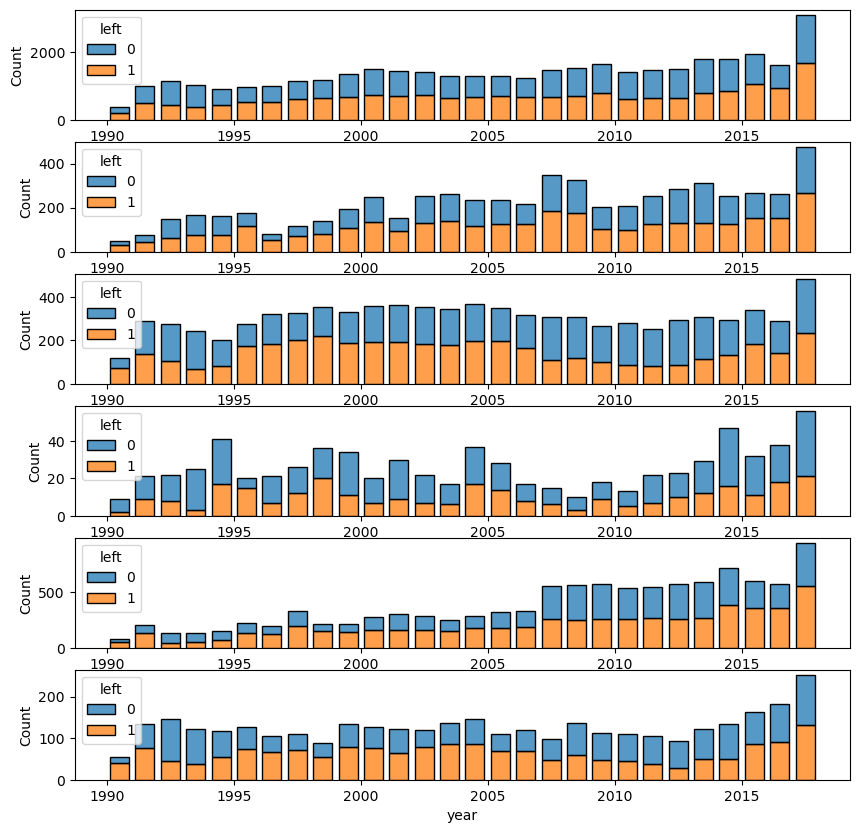

In [206]:
fig, ax = plt.subplots(6,1,figsize=(10,10))

for i, topic in enumerate(topic_list):
    sns.histplot(x = 'year', data = party_df.loc[party_df[topic] == 1], binwidth = 1, hue = 'left', ax=ax[i], 
                 multiple = 'stack', shrink = 0.75);

In [207]:
party_df.to_json(str(corp) + '_topic_df.json')